In [2]:
import pandas as pd

# Load the dataset
file_path = "encoded_data.csv"
data = pd.read_csv(file_path)

# Display the first few rows to understand the data structure
print(data.head())


  Accident_Index  Longitude   Latitude  Number_of_Vehicles  \
0  200501BS00001  -0.191170  51.489096                   1   
1  200501BS00002  -0.211708  51.520075                   1   
2  200501BS00003  -0.206458  51.525301                   2   
3  200501BS00004  -0.173862  51.482442                   1   
4  200501BS00005  -0.156618  51.495752                   1   

   Number_of_Casualties        Date  Day_of_Week      Time  Speed_limit  \
0                     1  04-01-2005            3  17:42:00           30   
1                     1  05-01-2005            4  17:36:00           30   
2                     1  06-01-2005            5  00:15:00           30   
3                     1  07-01-2005            6  10:35:00           30   
4                     1  10-01-2005            2  21:13:00           30   

   Urban_or_Rural_Area  ... Special_Conditions_at_Site_Mud  \
0                    1  ...                          False   
1                    1  ...                         

/var/folders/r0/kmkzmgh52q9f32w030w6nl_h0000gn/T/ipykernel_4750/3401761458.py:5: DtypeWarning: Columns (0,11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


In [4]:
# Extract relevant columns
geo_data = data[['Longitude', 'Latitude']].dropna()

# Display the preprocessed data
print(geo_data.head())


   Longitude   Latitude
0  -0.191170  51.489096
1  -0.211708  51.520075
2  -0.206458  51.525301
3  -0.173862  51.482442
4  -0.156618  51.495752


In [2]:
import pandas as pd

# Load the original CSV file
file_path = 'encoded_data.csv'

# Read the first 100,000 rows from the CSV file
data = pd.read_csv(file_path, nrows=100000)

# Save the extracted data to a new file
data.to_csv('clusteranalysis.csv', index=False)

print("First 1 lakh rows saved to clusteranalysis.csv")


First 1 lakh rows saved to clusteranalysis.csv


In [4]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
data = pd.read_csv("clusteranalysis.csv")
geo_data = data[['Longitude', 'Latitude']].dropna()
# Set parameters for DBSCAN
epsilon = 0.01  # Approximate radius for clustering in degrees
min_samples = 5  # Minimum number of points to form a cluster

# Apply DBSCAN
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples, metric='haversine').fit(np.radians(geo_data))
geo_data['Cluster'] = dbscan.labels_

# Display the number of clusters
n_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
print(f"Number of clusters: {n_clusters}")


Number of clusters: 2


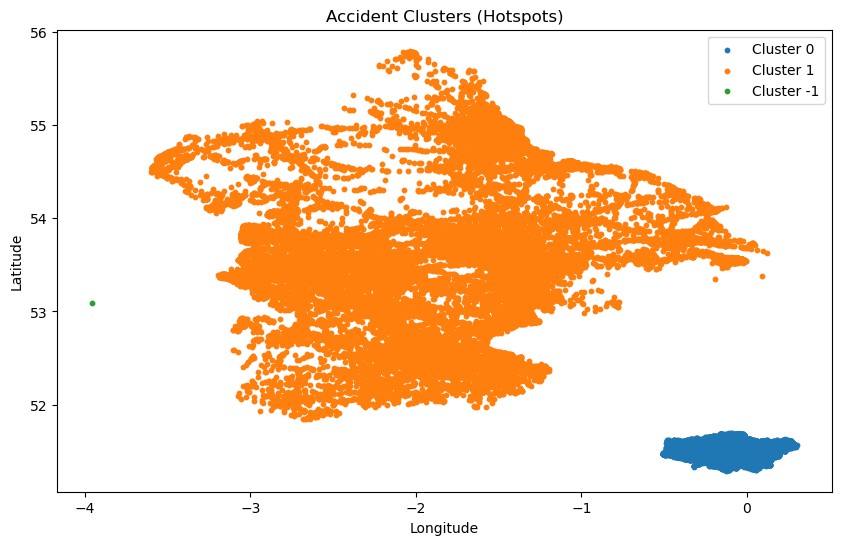

In [13]:
import matplotlib.pyplot as plt
# Plotting the clusters
plt.figure(figsize=(10, 6))
for cluster_label in set(geo_data['Cluster']):
    cluster_data = geo_data[geo_data['Cluster'] == cluster_label]
    plt.scatter(cluster_data['Longitude'], cluster_data['Latitude'], s=10, label=f'Cluster {cluster_label}')

plt.title('Accident Clusters (Hotspots)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


In [15]:
import geopandas as gpd
from shapely.geometry import Point

# Create a GeoDataFrame
geo_data['Coordinates'] = geo_data.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
gdf = gpd.GeoDataFrame(geo_data, geometry='Coordinates')

# Save as GeoJSON
gdf.to_file("hotspots.geojson", driver="GeoJSON")


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


In [17]:
from shapely.geometry import Point

# Function to check if a location is in a cluster
def is_in_hotspot(longitude, latitude, geojson_file="hotspots.geojson"):
    hotspots = gpd.read_file(geojson_file)
    point = Point(longitude, latitude)
    for _, row in hotspots.iterrows():
        if row['geometry'].contains(point):
            return True
    return False

# Example check
example_longitude = -0.19117
example_latitude = 51.489096
print(is_in_hotspot(example_longitude, example_latitude))


True


In [21]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Load your data (replace 'encoded_data.csv' with your actual file path)
df = pd.read_csv('encoded_data.csv')

# Check if your data has latitude and longitude columns
# If columns are named differently, adjust them accordingly
print(df.columns)  # To check the column names

# Create a GeoDataFrame from latitude and longitude columns
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Check if 'geometry' column exists
print(gdf.columns)

# Create buffer zones around each accident hotspot (point) with 100 meters radius
gdf['Buffer'] = gdf['geometry'].buffer(0.001)  # 0.001 ~ 100 meters (adjust buffer size as needed)

# Save the GeoDataFrame with buffers as GeoJSON
gdf.to_file("hotspots_with_buffers.geojson", driver="GeoJSON")

# Optional: visualize the data with buffers
import matplotlib.pyplot as plt

# Plot the accident clusters (hotspots)
ax = gdf.plot(column='Buffer', figsize=(10, 10), cmap='coolwarm', legend=True)
ax.set_title("Accident Clusters (Hotspots)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()



/var/folders/r0/kmkzmgh52q9f32w030w6nl_h0000gn/T/ipykernel_5362/2715549272.py:6: DtypeWarning: Columns (0,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('encoded_data.csv')


Index(['Accident_Index', 'Longitude', 'Latitude', 'Number_of_Vehicles',
       'Number_of_Casualties', 'Date', 'Day_of_Week', 'Time', 'Speed_limit',
       'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'LSOA_of_Accident_Location', 'Year', 'Month', 'Weekday', 'Hour',
       'Minute', 'Second', 'Weather_Conditions_Fine with high winds',
       'Weather_Conditions_Fine without high winds',
       'Weather_Conditions_Fog or mist', 'Weather_Conditions_Other',
       'Weather_Conditions_Raining with high winds',
       'Weather_Conditions_Raining without high winds',
       'Weather_Conditions_Snowing with high winds',
       'Weather_Conditions_Snowing without high winds',
       'Weather_Conditions_Unknown', 'Road_Type_Dual', 'Road_Type_One-way',
       'Road_Type_Roundabout', 'Road_Type_Single', 'Road_Type_Slip',
       'Road_Type_Unknown', 'Accident_Severity_1', 'Accident_Severity_2',
       'Accident_Severity_3', 'Junction_Control_Authorised person',
     

ValueError: GeoDataFrame contains multiple geometry columns but GeoDataFrame.to_file supports only a single geometry column. Use a GeoDataFrame.to_parquet or GeoDataFrame.to_feather, drop additional geometry columns or convert them to a supported format like a well-known text (WKT) using `GeoSeries.to_wkt()`.

/var/folders/r0/kmkzmgh52q9f32w030w6nl_h0000gn/T/ipykernel_5362/412322477.py:6: DtypeWarning: Columns (0,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('encoded_data.csv')


Index(['Accident_Index', 'Longitude', 'Latitude', 'Number_of_Vehicles',
       'Number_of_Casualties', 'Date', 'Day_of_Week', 'Time', 'Speed_limit',
       'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'LSOA_of_Accident_Location', 'Year', 'Month', 'Weekday', 'Hour',
       'Minute', 'Second', 'Weather_Conditions_Fine with high winds',
       'Weather_Conditions_Fine without high winds',
       'Weather_Conditions_Fog or mist', 'Weather_Conditions_Other',
       'Weather_Conditions_Raining with high winds',
       'Weather_Conditions_Raining without high winds',
       'Weather_Conditions_Snowing with high winds',
       'Weather_Conditions_Snowing without high winds',
       'Weather_Conditions_Unknown', 'Road_Type_Dual', 'Road_Type_One-way',
       'Road_Type_Roundabout', 'Road_Type_Single', 'Road_Type_Slip',
       'Road_Type_Unknown', 'Accident_Severity_1', 'Accident_Severity_2',
       'Accident_Severity_3', 'Junction_Control_Authorised person',
     

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

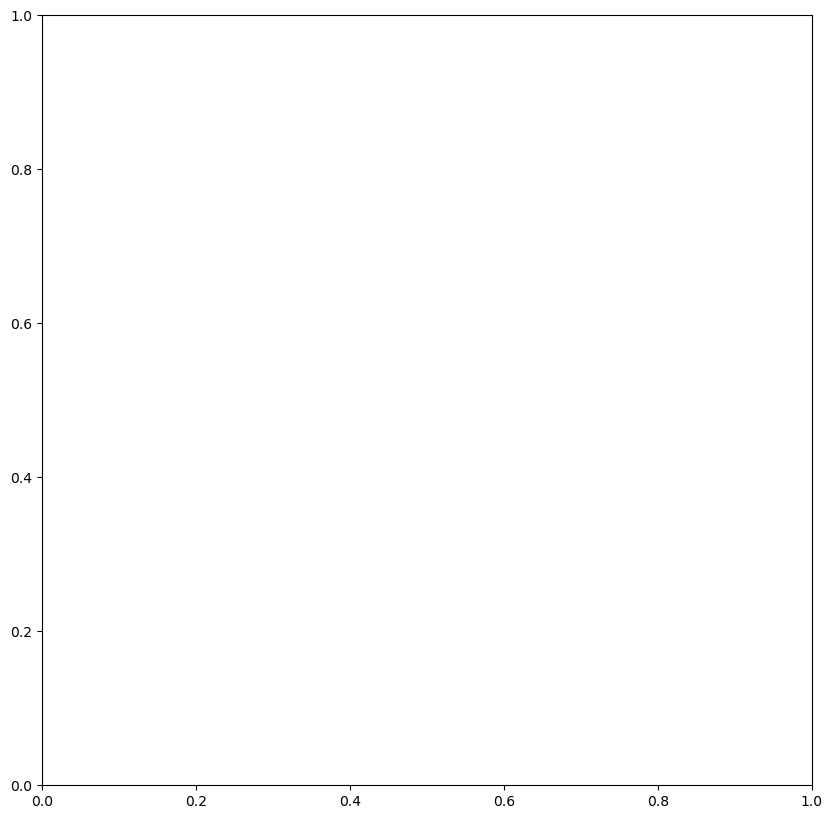

In [23]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Load your data (replace 'encoded_data.csv' with your actual file path)
df = pd.read_csv('encoded_data.csv')

# Check if your data has latitude and longitude columns
# If columns are named differently, adjust them accordingly
print(df.columns)  # To check the column names

# Create a GeoDataFrame from latitude and longitude columns
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Check if 'geometry' column exists
print(gdf.columns)

# Create buffer zones around each accident hotspot (point) with 100 meters radius
gdf['Buffer'] = gdf['geometry'].buffer(0.001)  # 0.001 ~ 100 meters (adjust buffer size as needed)

# Now drop the original 'geometry' column to avoid multiple geometry columns
gdf = gdf.drop(columns='geometry')

# Rename 'Buffer' column to 'geometry' so it becomes the single geometry column
gdf = gdf.rename(columns={'Buffer': 'geometry'})

# Save the GeoDataFrame with buffers as GeoJSON
gdf.to_file("hotspots_with_buffers.geojson", driver="GeoJSON")

# Optional: visualize the data with buffers
import matplotlib.pyplot as plt

# Plot the accident clusters (hotspots)
ax = gdf.plot(column='geometry', figsize=(10, 10), cmap='coolwarm', legend=True)
ax.set_title("Accident Clusters (Hotspots)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()


In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Load your data (replace 'encoded_data.csv' with your actual file path)
df = pd.read_csv('encoded_data.csv')

# Create a GeoDataFrame from latitude and longitude columns
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Ensure GeoDataFrame uses the correct CRS (Coordinate Reference System)
# Start with EPSG:4326 for lat/lon, then project to a CRS that uses meters (e.g., EPSG:3857)
gdf = gdf.set_crs('EPSG:4326')  # Set initial CRS (lat/lon)
gdf = gdf.to_crs(epsg=3857)  # Convert to a CRS that uses meters for distance calculations

# Create buffer zones around each accident hotspot (point) with a larger radius (e.g., 100 meters)
gdf['Buffer'] = gdf['geometry'].buffer(100)  # Buffer size is now 100 meters

# Drop the original 'geometry' column and rename 'Buffer' to 'geometry'
gdf = gdf.drop(columns='geometry')
gdf = gdf.rename(columns={'Buffer': 'geometry'})

# Save the GeoDataFrame with buffers as GeoJSON
gdf.to_file("hotspots_with_buffers.geojson", driver="GeoJSON")

# Optional: visualize the data with buffers
ax = gdf.plot(column='geometry', figsize=(10, 10), cmap='coolwarm', legend=True)
ax.set_title("Accident Clusters (Hotspots) with Buffers")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()


/var/folders/r0/kmkzmgh52q9f32w030w6nl_h0000gn/T/ipykernel_5362/4080926389.py:7: DtypeWarning: Columns (0,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('encoded_data.csv')
